In [1]:
from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store
from IPython.display import JSON

Which data stores are available?

In [2]:
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

Get a specific store

Usually we need more information to get the actual data store object. Which data store parameters are available?

In [3]:
get_data_store_params_schema('directory')

Just provide mandatory parameters to instantiate the store class:

In [4]:
store = new_data_store('directory', base_dir='../serve/demo')
store

Which datasets are provided? (the list may contain both gridded and vector datasets):

In [5]:
JSON(list(store.get_data_ids()))

<IPython.core.display.JSON object>

Get more info about a dedicated dataset. This include a description of the possible open formats:

In [6]:
store.describe_data('cube-1-250-250.zarr')

Which "openers" are available? Note, the first part of an opener's name identifies the returned in-memory data type:

- `dataset` --> `xarray.Dataset` (Gridded data)
- `mldataset` -->  `xcube.core.mlds.MultiLevelDataset`  (Gridded data, multi-resolution pyramid)
- `geodataframe` --> `geopandas.GeoDataFrame` (Vector data) 

In [7]:
store.get_data_opener_ids()

('dataset:netcdf:posix',
 'dataset:zarr:posix',
 'geodataframe:shapefile:posix',
 'geodataframe:geojson:posix')

Which parameters must I pass or are available to open the dataset?

In [8]:
store.get_open_data_params_schema('cube-1-250-250.zarr')

There are no required parameters, so we can open the dataset without any parameters:

In [9]:
dataset = store.open_data('cube-1-250-250.zarr')
dataset

<xarray.Dataset>
Dimensions:        (bnds: 2, lat: 1000, lon: 2000, time: 5)
Coordinates:
  * lat            (lat) float64 52.5 52.5 52.49 52.49 ... 50.01 50.01 50.0 50.0
    lat_bnds       (lat, bnds) float64 dask.array<chunksize=(250, 2), meta=np.ndarray>
  * lon            (lon) float64 0.00125 0.00375 0.00625 ... 4.994 4.996 4.999
    lon_bnds       (lon, bnds) float64 dask.array<chunksize=(250, 2), meta=np.ndarray>
  * time           (time) datetime64[ns] 2017-01-16T10:09:21.834255872 ... 2017-01-30T10:46:33.836892416
    time_bnds      (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    c2rcc_flags    (time, lat, lon) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    conc_chl       (time, lat, lon) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    conc_tsm       (time, lat, lon) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    kd489          (time, lat, lon) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    quality_flags  (time, lat, lon) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7

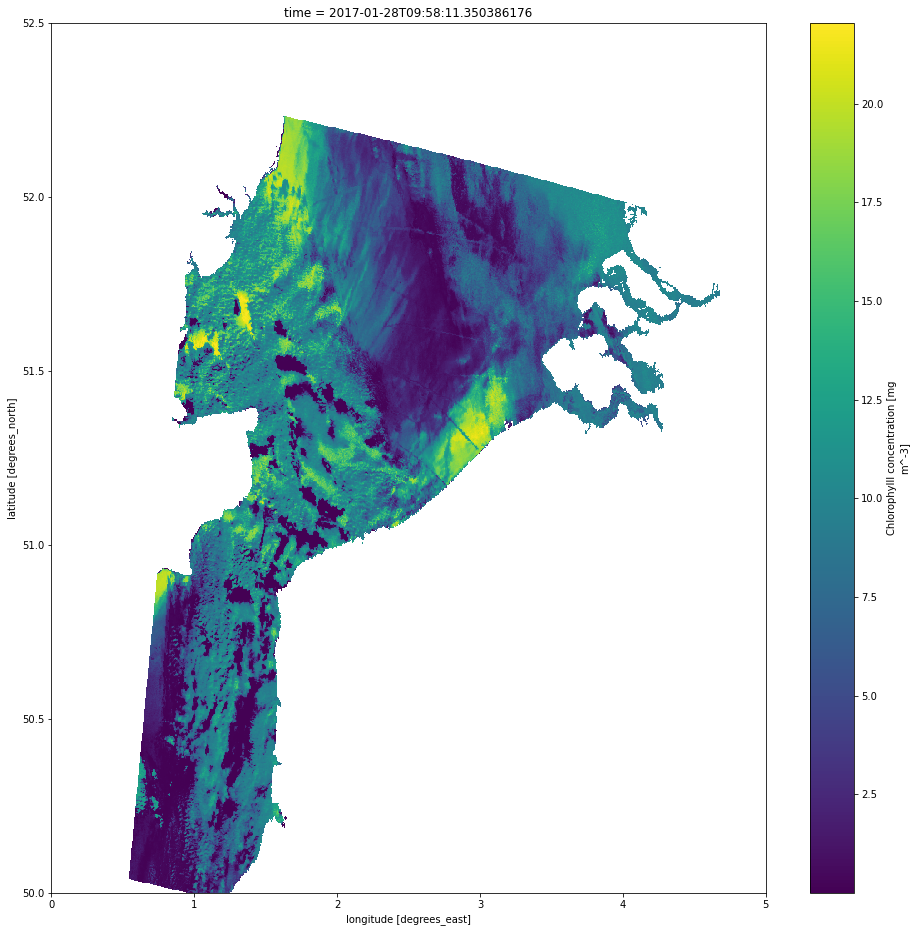

In [10]:
dataset.conc_chl.isel(time=3).plot.imshow(figsize=(16, 16))

Do some data processing. Here we just create spatial subset.

In [27]:
new_dataset = dataset.sel(lon=slice(2.8, 4.75), lat=slice(52.1, 51.2))
new_dataset

<xarray.Dataset>
Dimensions:        (bnds: 2, lat: 360, lon: 780, time: 5)
Coordinates:
  * lat            (lat) float64 52.1 52.1 52.09 52.09 ... 51.21 51.21 51.2 51.2
    lat_bnds       (lat, bnds) float64 dask.array<chunksize=(90, 2), meta=np.ndarray>
  * lon            (lon) float64 2.801 2.804 2.806 2.809 ... 4.744 4.746 4.749
    lon_bnds       (lon, bnds) float64 dask.array<chunksize=(130, 2), meta=np.ndarray>
  * time           (time) datetime64[ns] 2017-01-16T10:09:21.834255872 ... 2017-01-30T10:46:33.836892416
    time_bnds      (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    c2rcc_flags    (time, lat, lon) float64 dask.array<chunksize=(1, 90, 130), meta=np.ndarray>
    conc_chl       (time, lat, lon) float64 dask.array<chunksize=(1, 90, 130), meta=np.ndarray>
    conc_tsm       (time, lat, lon) float64 dask.array<chunksize=(1, 90, 130), meta=np.ndarray>
    kd489          (time, lat, lon) float64 dask.array<chunksize=(1, 90, 130), meta=np.ndarray>
    quality_flags  (time, lat, lon) float64 dask.array<chunksize=(1, 90, 130), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7

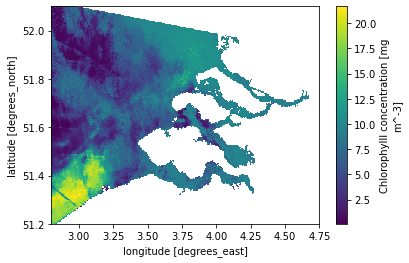

In [18]:
var = new_dataset.conc_chl.isel(time=3).drop('time')
var.plot.imshow()

Now let's store the processed data. Which writers are available?

In [19]:
store.get_data_writer_ids()

('dataset:netcdf:posix',
 'dataset:zarr:posix',
 'geodataframe:shapefile:posix',
 'geodataframe:geojson:posix')

Which write parameters are required/available for writer `'dataset:zarr:posix'`?

In [25]:
store.get_write_data_params_schema(writer_id='dataset:zarr:posix')

In [30]:
# Rechunk
import xarray as xr
new_dataset = new_dataset.chunk(dict(lat=90, lon=90, time=1))
# new_dataset

No write parameters required, so we go without:

In [26]:
store.write_data(new_dataset, 'cube-1-250-250-subset.zarr', writer_id='dataset:zarr:posix')

NotImplementedError: Specified zarr chunks (1, 250, 250) would overlap multiple dask chunks ((1, 1, 1, 1, 1), (90, 90, 90, 90), (90, 90, 90, 90, 90, 90, 90, 90, 60)). This is not implemented in xarray yet.  Consider rechunking the data using `chunk()` or specifying different chunks in encoding.

In [22]:
JSON(list(store.get_data_ids()))

<IPython.core.display.JSON object>

In [23]:
store.delete_data('cube-1-250-250-subset.zarr')

In [24]:
JSON(list(store.get_data_ids()))

<IPython.core.display.JSON object>